In [1]:
import numpy as np
import pandas as pd
import warnings
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from re import sub
import pickle

warnings.filterwarnings('ignore')

In [2]:
# model packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from scipy.optimize import minimize

In [3]:
df = pd.read_csv('data/calendar_compiled.csv')
df_calendar = df.drop(['Unnamed: 0'], axis =1)
df_listing = pd.read_csv('data/listings.csv')

##  EDA

1. Data Cleaning: Type Conversion

In [4]:
# convert time info
df_calendar['date'] = pd.to_datetime(df_calendar['date'], format='%Y%m%d') 
df_calendar['dayWeek'] = df_calendar['date'].dt.day_name()
df_calendar['month'] = df_calendar['date'].dt.month

df_listing['host_since'] = pd.to_datetime(df_listing['host_since'])

In [5]:
# change price columns
price_columns = ['price', 'weekly_price', 'monthly_price','security_deposit', 'cleaning_fee',  'extra_people']
for price in price_columns:
    df_listing[price] = df_listing[price].apply(lambda x:  x if (x != x) else float(sub(r'[^\d.]', '', x)))

In [6]:
# zip code
df_listing['zipcode'] = df_listing.zipcode.apply(lambda x: x if (x != x) else x[-4:])

2. Data Integration: Merge according to list_id and id

In [7]:
# merge according to list_id and id
df_all = df_calendar.merge(df_listing, left_on = 'listing_id', right_on = 'id', suffixes=('_daily', '_average'))
df_all = df_all.drop(['id'], axis = 1)

3. Columns of interest

In [8]:
column_interested = ['listing_id', 'date', 'price_daily', 'unavailable', 'dayWeek', 'month', 'host_since', 'zipcode', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
'beds', 'bed_type','security_deposit', 'cleaning_fee','guests_included', 'extra_people']

df_clean = df_all[column_interested]

In [9]:
# future interest
# host_info, name, host_about...

3. Missing Values and Imputation

In [10]:
df_clean.isna().sum()[df_clean.isna().sum() != 0]

zipcode               8457
bathrooms             1002
bedrooms               553
security_deposit    383308
cleaning_fee        203423
dtype: int64

In [11]:
impute_zero = ['security_deposit', 'cleaning_fee', 'bathrooms', 'bedrooms']
keep_nan = ['zipcode']

df_clean[impute_zero] = df_clean[impute_zero].fillna(0)

4. feature engineering

In [12]:
# create host_length (enter 0 when doing our optimization)
df_clean['host_length'] = (df_clean['date'] - df_clean['host_since']).dt.days

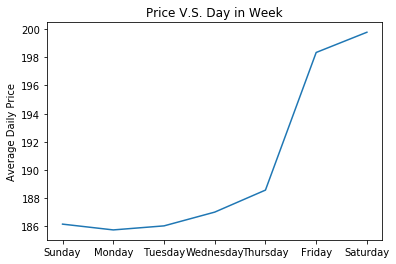

In [13]:
# extract important features from date info
weekDay_price = df_clean.groupby(['dayWeek'])['price_daily'].mean()

weekDay_order_index = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekDay_oder_value = [weekDay_price[x] for x in weekDay_order_index]

plt.plot(weekDay_order_index, weekDay_oder_value)
plt.ylabel('Average Daily Price')
plt.title('Price V.S. Day in Week');

We can see that the price for Friday and Saturday are significantly different from the other days in the week. Therefore, we created a categorical feature 'weekend' (including Friday and Saturday).

In [14]:
df_clean['weekend'] = df_clean['dayWeek'].isin(['Friday', 'Saturday'])

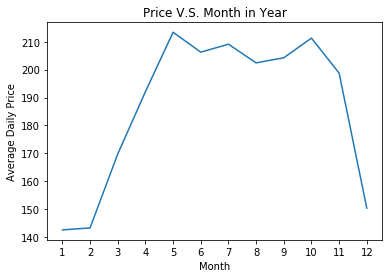

In [15]:
# extract month pattern
month_price = df_clean.groupby(['month'])['price_daily'].mean()

month_order_index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_oder_value = [month_price[x] for x in month_order_index]

plt.plot(np.array(month_order_index)-1, month_oder_value)
plt.xticks(range(12), month_order_index)
plt.xlabel('Month')
plt.ylabel('Average Daily Price')
plt.title('Price V.S. Month in Year');

From the plot we can see that, each year from May to October is the peak, then comes (March, April, November), and the remaining are the slack season. Therefore we created a categorical feature 'peak_month', which has Peak (May to Oct), Middle(March, April, November) and Slack(Jan, Feb, Dec). 

In [16]:
def classify_month(x):
    if x in [5,6,7,8,9,10]:
        return 'Peak'
    elif x in[3,4,11]:
        return 'Middle'
    else:
        return 'Slack'

df_clean['peak_month'] = df_clean['month'].apply(classify_month)

In [17]:
# one-hot for categorical column (>= 3 categories)
to_categorical = ['zipcode', 'property_type', 'room_type', 'bed_type', 'peak_month']


df_final = pd.concat([df_clean, pd.get_dummies(df_clean[to_categorical],
                                              prefix=['zipcode_', 'propertyType_', 'roomType_', 'bedType_', 'peakMonth_'], 
                                              drop_first=True)], axis = 1)

In [18]:
not_features = ['listing_id','date','unavailable','dayWeek','month','host_since'] + to_categorical

In [19]:
X = df_final.drop(not_features, axis = 1)
Y = df_final['unavailable']

The features we have:
- price_daily
- host info: host_length (when doing optimization for new hosts, set 0)
- time info: weekend, peak_month
- property info: zipcode, property type, room type, bed type, acommodates, bathrooms, bedrooms, beds, guests_included, extra_people
- related fees info: security_deposit, cleaning_fee

## Predictive Model (The probability of getting rent)

In this predictive model, we are finding the mapping for (price, other variables) to (the probability of getting rent)

The probability of Being Rent is 0.62


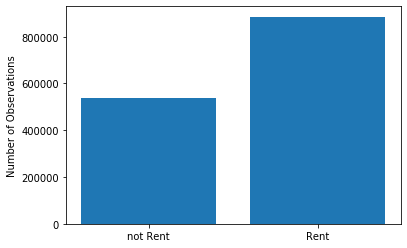

In [20]:
# Data Balance check
plt.bar([1,2], [len(Y)-np.sum(Y), np.sum(Y)])
plt.xticks([1,2], ['not Rent', 'Rent'])
plt.ylabel('Number of Observations');
print('The probability of Being Rent is {0:4.2f}'.format(np.sum(Y)/len(Y)))

From the plot above we can see that, the data does not have a severe imbalance problem in response variable, so we do not need to take further actions.

1. Train-Test Split

In [21]:
X_TRAIN, X_test, Y_TRAIN,  y_test = train_test_split(X, Y, test_size = 0.1, random_state = 2019)
X_train, X_val, y_train,  y_val = train_test_split(X_TRAIN, Y_TRAIN, test_size = 0.2, random_state = 2019)

print('# Training Images: {}'.format(len(X_train)))
print('# Validation Images: {}'.format(len(X_val)))
print('# Test Images: {}'.format(len(X_test)))

# Training Images: 1025171
# Validation Images: 256293
# Test Images: 142385


2. Logistic Regression (with built-in cross validation for selecting Cs values and l1_ratios)

In [22]:
k = KFold(5, random_state = 2019, shuffle=True)
clf = LogisticRegressionCV(cv = k, random_state = 2019).fit(X_TRAIN, Y_TRAIN)

In [23]:
print('The accuracy for Logistic Regression on Test set is {0:6.4f}'.format(clf.score(X_test, y_test)))

The accuracy for Logistic Regression on Test set is 0.6712


In [29]:
pickle.dump(clf, open('logistic.sav', 'wb'))
# loaded_model = pickle.load(open('logistic.sav', 'rb'))

3. KNN (with cross validation for selecting n_neighbors)

In [24]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 10, 2)}
knn_gscv = GridSearchCV(knn, param_grid, cv = k)
knn_gscv.fit(X_TRAIN, Y_TRAIN)

GridSearchCV(cv=KFold(n_splits=5, random_state=2019, shuffle=True),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([1, 3, 5, 7, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [26]:
print('The accuracy for KNN on Test set is {0:6.4f}'.format(knn_gscv.score(X_test, y_test)))

The accuracy for KNN on Test set is 0.9092


In [30]:
pickle.dump(knn_gscv, open('knn_gscv.sav', 'wb'))

4. LDA/QDA

In [94]:
lda = LinearDiscriminantAnalysis().fit(X_TRAIN, Y_TRAIN)#(X_blobs,y_blobs)
qda = QuadraticDiscriminantAnalysis().fit(X_TRAIN, Y_TRAIN)#(X_blobs,y_blobs)

In [95]:
print('The accuracy for LDA on Test set is {0:6.4f}'.format(lda.score(X_test, y_test)))
print('The accuracy for LDA on Test set is {0:6.4f}'.format(qda.score(X_test, y_test)))

The accuracy for LDA on Test set is 0.6721
The accuracy for LDA on Test set is 0.3887


In [96]:
pickle.dump(lda, open('lda.sav', 'wb'))
pickle.dump(qda, open('qda.sav', 'wb'))

5. Classification Trees

## Optimization Model (Find Price that Maximized the Expected Return)

According to the predictive model above, we found a mapping from (Price, other features) -> the probability of property getting rent. Given the value for other features, we have a function $F$, that takes the price and return the probability of being rent.

The goal for our project is to help the new host optimize the expected Return, which is:
$$ \text{Price}*{\text{P}} = \text{Price} * \text{F}(\text{Price})$$

To make the use of recent packages, we will try to minimize the negative,
$$\underset{price}{\operatorname{argmin}} \{- \text{Price} * \text{F}(\text{Price})\}$$

In [54]:
def get_prob(price,model):
    X_blank = pd.DataFrame(X_test.iloc[0]).T # use the values in other columns for convenience
    X_blank['price_daily'] = price
    prob = model.predict_proba(X_blank)[0][-1] # use the model here
    return prob

def minimize_objective(price, *args):
    return - price * get_prob(price, args[0])

In [99]:
print('clf')
initial_price = 100
model = clf
solution = minimize(minimize_objective, initial_price, args = (model),method = 'SLSQP', tol = 1e-6)
print('The Suggested Price is {0:4.2f}'.format(solution.x[0]))
print('The Expected Return is {0:4.2f}, with the probability of being rent is {1:4.2f}'.format(-solution.fun, get_prob(solution.x, model)))

print('\nknn')
initial_price = 100
model = knn_gscv
solution = minimize(minimize_objective, initial_price, args = (model),method = 'SLSQP', tol = 1e-6)
print('The Suggested Price is {0:4.2f}'.format(solution.x[0]))
print('The Expected Return is {0:4.2f}, with the probability of being rent is {1:4.2f}'.format(-solution.fun, get_prob(solution.x, model)))

print('\nlda')
initial_price = 100
model = lda
solution = minimize(minimize_objective, initial_price, args = (model),method = 'SLSQP', tol = 1e-6)
print('The Suggested Price is {0:4.2f}'.format(solution.x[0]))
print('The Expected Return is {0:4.2f}, with the probability of being rent is {1:4.2f}'.format(-solution.fun, get_prob(solution.x, model)))

print('\nqda')
initial_price = 100
model = qda
solution = minimize(minimize_objective, initial_price, args = (model),method = 'SLSQP', tol = 1e-6)
print('The Suggested Price is {0:4.2f}'.format(solution.x[0]))
print('The Expected Return is {0:4.2f}, with the probability of being rent is {1:4.2f}'.format(-solution.fun, get_prob(solution.x, model)))


clf
The Suggested Price is 741.37
The Expected Return is 115.57, with the probability of being rent is 0.16

knn
The Suggested Price is 100.00
The Expected Return is 0.00, with the probability of being rent is 0.00

lda
The Suggested Price is 1027.29
The Expected Return is 148.64, with the probability of being rent is 0.14

qda
The Suggested Price is 100.00
The Expected Return is 0.00, with the probability of being rent is 0.00


In [93]:
knn_gscv.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [90]:
X_blank = pd.DataFrame(X_test.iloc[0]).T # use the values in other columns for convenience
X_blank['price_daily'] = 741
clf.predict(X_blank), knn_gscv.predict_proba(X_blank)

(array([0]), array([[0., 1.]]))